In [1]:
!git clone https://github.com/yucaoyc/OptimalDiffusion.git

Cloning into 'OptimalDiffusion'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 168 (delta 81), reused 143 (delta 56), pack-reused 0 (from 0)
Receiving objects: 100% (168/168), 11.59 MiB | 11.37 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Updating files: 100% (63/63), done.


In [4]:
#! -*-coding:utf-8 -*-
import sys
sys.path.append('/content/OptimalDiffusion')
sys.path.append('/content/OptimalDiffusion/Toy_examples')

import os
import torch
import time
import numpy as np

from OptimalDiffusion.Toy_examples.lib.sde import SDE
from OptimalDiffusion.Toy_examples.lib.utils import visualize_diffusion_process_1d, visualize_diffusion_process_2d, visualize_diffusion_process_2d_marginal, visualize_line
from OptimalDiffusion.Toy_examples.lib.utils import weight_init
from OptimalDiffusion.Toy_examples.lib.data import GMM
from OptimalDiffusion.Toy_examples.lib.evaluate import evaluate_1d, evaluate_2d

torch.set_default_dtype(torch.float64)


In [16]:
## hyper-parameters
T = 1.0                                     # the terminal time
sample_size = 10000                         # the number of random samples
N = 5                                       # control the number of visualizations
h_alphas = [0.0, 1.0, 2.0, 3.0, 4.0]        # candidates for h


# GMM 1D

In [6]:
data_type = "gmm1d"
reverse_N = 40000                           # number of discretization steps

## define data

mus = np.array([-1.0, 1.0]).reshape(-1, 1)
sigms = np.array([0.1, 0.1]).reshape(-1, 1)
ps = np.array([0.5, 0.5])

true_data = GMM(mus=mus, sigmas=sigms, ps=ps, data_dim=1)

x0, x1 = -3.0, 3.0         # the range of x coordinate to visualize and compute divergences

data_dim = true_data.data_dim   # dimension of swissroll (=2)

## define sde model
beta0 = 1.0                     # beta at t = 0
beta1 = 1.0                    # beta at t = T

model = SDE(T=T, beta0=beta0, beta1=beta1, sde_type="vp", beta_type="linear", data_dim=data_dim, hidden_dim=50)
model.apply(weight_init)

## create directories for saving results
model_dir = f"sde_{data_type}_T-{T:.2f}"
output_dir = f"outputs/{model_dir}"
ckpt_dir = f"ckpts/{model_dir}"

if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir, exist_ok=True)

## Visualize the forward process

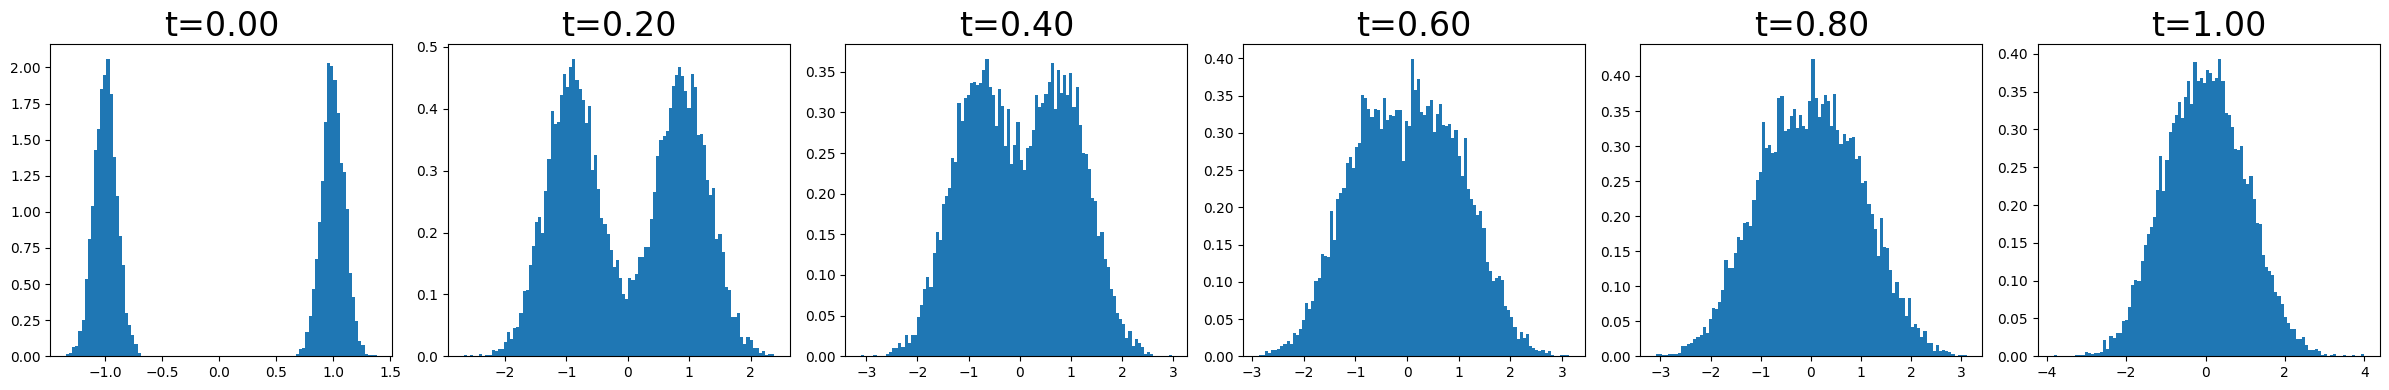

In [17]:
## visualize forward process
t_unit = T / N
t_schedule = np.arange(N + 1) * t_unit

# forward process
x_0 = true_data.sample(sample_size)
x_0 = torch.from_numpy(x_0).view(-1, data_dim)

x_t = list()

for t in t_schedule:

    x_t.append(model.forward_sde(x_0, t, to_numpy=True))

x_t = np.stack(x_t, axis=0)
visualize_diffusion_process_1d(xs=x_t, titles=[f"t={t:.2f}" for t in t_schedule], savename="vis_the_forward_process.png")


## Define the score corrupter

In [8]:
class CorruptScore(object):

    def __init__(self, T, error_type="1") -> None:
        self.T = T

        if error_type == "1":
            self.err_fun = self._error_1

        elif error_type == "2":
            self.err_fun = self._error_2

        elif error_type == "3":
            self.err_fun = self._error_3

        else:
            raise ValueError

    def _error_1(self, score, t, eps=1e-2):
        return (1 + eps) * score

    def _error_2(self, score, t, eps=1e-2):
        return (1 + eps * (1 + np.sin(2 * np.pi * t / self.T)) / 2) * score

    def _error_3(self, score, t, eps=1e-2):
        if t > 0.05 * self.T:
            return (1 + eps) * score
        return score



## Visualiza the reverse process

sampling with alpha=0.00 done, cost 54.81s
sampling with alpha=1.00 done, cost 54.91s
sampling with alpha=2.00 done, cost 57.27s
sampling with alpha=3.00 done, cost 52.20s
sampling with alpha=4.00 done, cost 50.99s


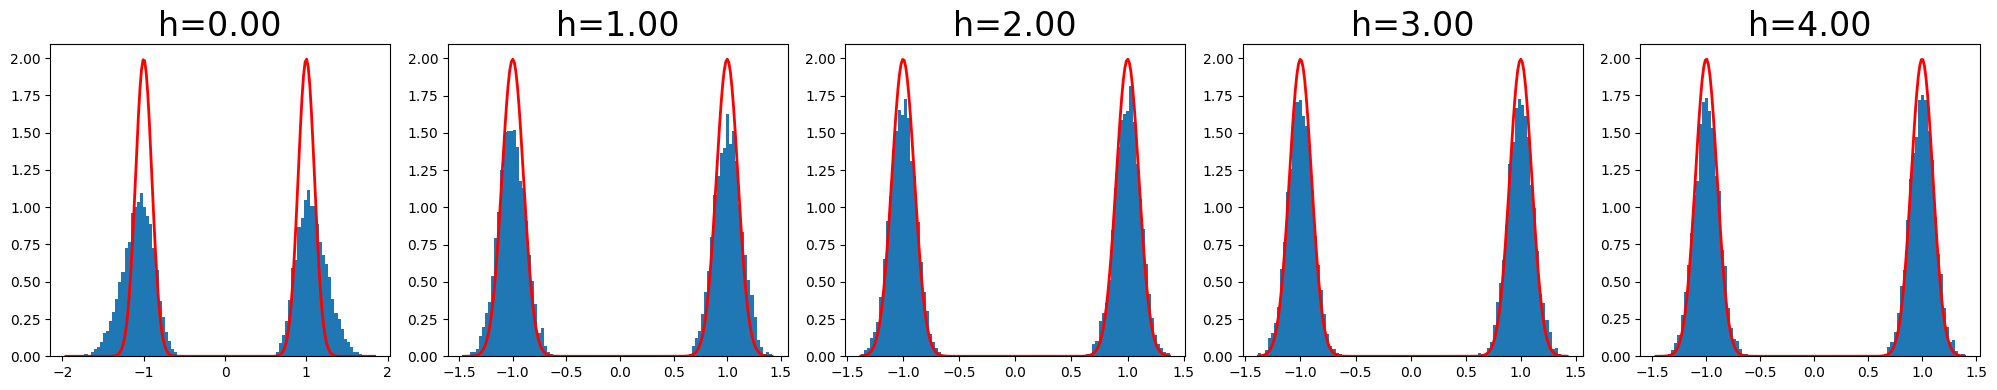

In [12]:
# build the score corrupter
Corrupter = CorruptScore(T=T, error_type="1")
eps = -0.20

x_T = torch.randn(sample_size, data_dim)

# run the reverse process
tilde_x_t = list()

for h_alpha in h_alphas:

    tic = time.time()
    tilde_x_t.append(model.sample(x_t=x_T, T=0.0, N=reverse_N, to_numpy=True, sf_alpha=h_alpha, exact_score_fn=true_data.exact_score_t, corrupter=Corrupter, eps=eps))
    toc = time.time()

    print(f"sampling with alpha={h_alpha:.2f} done, cost {toc - tic:.2f}s")

tilde_x_t = np.stack(tilde_x_t, axis=0)

# visualization
visualize_diffusion_process_1d(xs=tilde_x_t, titles=[f"h={h:.2f}" for h in h_alphas], density_func=true_data.p_t, savename="vis_the_reverse_process.png")

## Evaluate

h=4.00: js=0.0821, kl=0.0040, wd=0.0249
h=3.56: js=0.0653, kl=0.0027, wd=0.0185
h=3.11: js=0.0732, kl=0.0037, wd=0.0222
h=2.67: js=0.0753, kl=0.0034, wd=0.0241
h=2.22: js=0.0666, kl=0.0027, wd=0.0209
h=1.78: js=0.0748, kl=0.0036, wd=0.0240
h=1.33: js=0.0950, kl=0.0055, wd=0.0312
h=0.89: js=0.1450, kl=0.0124, wd=0.0460
h=0.44: js=0.2412, kl=0.0332, wd=0.0779
h=0.00: js=0.2947, kl=0.0487, wd=0.0969


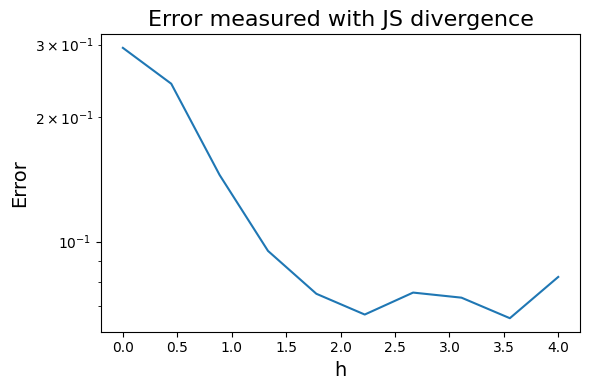

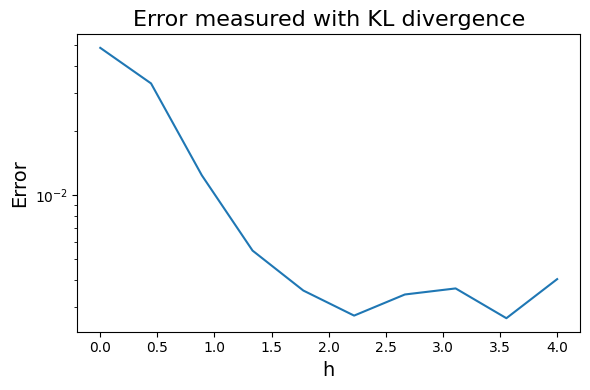

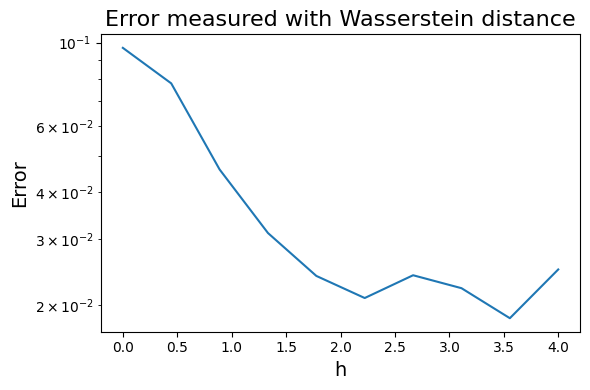

In [19]:
data = list()

for h in np.linspace(start=0.0, stop=h_alphas[-1], num=10, endpoint=True)[::-1]:
# for sa in [sf_alpha]:

    x_0 = true_data.sample(sample_size)
    x_0 = torch.from_numpy(x_0).view(-1, data_dim)

    x_0_gen = model.sample(x_t=x_T, T=0.0, N=reverse_N, to_numpy=True, sf_alpha=h, exact_score_fn=true_data.exact_score_t, corrupter=Corrupter, eps=eps)

    js, kl, wd = evaluate_1d(true_data=x_0.detach().numpy(), fake_data=x_0_gen, x0=x0, x1=x1)

    print(f"h={h:.2f}: js={js:.4f}, kl={kl:.4f}, wd={wd:.4f}")

    data.append([h, js, kl, wd])

data = np.array(data)

visualize_line(data=data[:, 1], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with JS divergence", savename="eval_JS.png")
visualize_line(data=data[:, 2], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with KL divergence", savename="eval_KL.png")
visualize_line(data=data[:, 3], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with Wasserstein distance", savename="eval_WD.png")



# GMM 2D

In [20]:
data_type = "gmm1d"
reverse_N = 80000           # number of discretization steps

# define data

mus = np.array([[-1.0, -1.0], [-1.0, 1.0], [1.0, 1.0], [1.0, -1.0],]).reshape(-1, 2)
sigms = np.array([0.05, 0.05, 0.05, 0.05]).reshape(-1, 1)
ps = np.array([0.25, 0.25, 0.25, 0.25])

true_data = GMM(mus=mus, sigmas=sigms, ps=ps, data_dim=2)

data_dim = true_data.data_dim

x0, x1 = -2.5, 2.5          # the range of x coordinate to visualize and compute divergences
y0, y1 = -2.5, 2.5          # the range of y coordinate to visualize and compute divergences


## Visualize the forward process

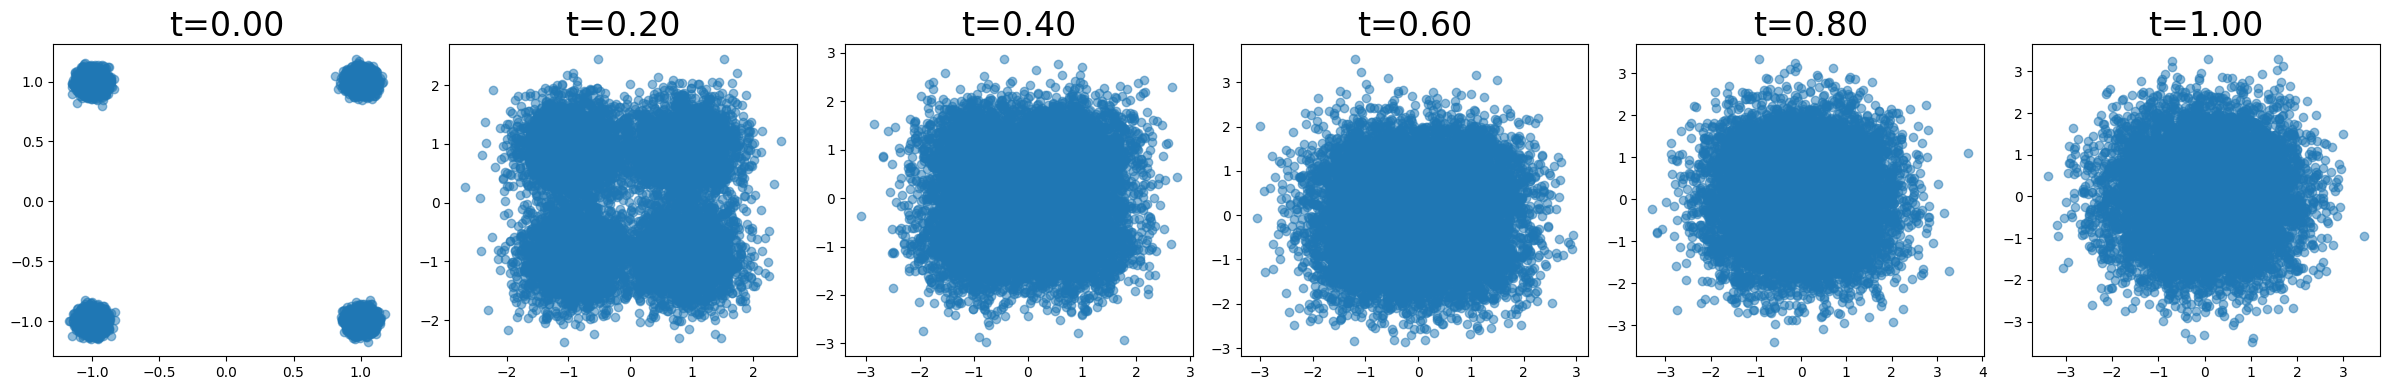

Image has been saved to vis_the_forward_process_2.png


In [22]:
## visualize forward process
t_unit = T / N
t_schedule = np.arange(N + 1) * t_unit

# forward process
x_0 = true_data.sample(sample_size)
x_0 = torch.from_numpy(x_0).view(-1, data_dim)

x_t = list()

for t in t_schedule:

    x_t.append(model.forward_sde(x_0, t, to_numpy=True))

x_t = np.stack(x_t, axis=0)
visualize_diffusion_process_2d(xs=x_t, titles=[f"t={t:.2f}" for t in t_schedule], savename="vis_the_forward_process_2.png")


In [24]:
# build the score corrupter
h_alphas = [0.0, 2.0, 4.0]

Corrupter = CorruptScore(T=T, error_type="1")
eps = -0.20

x_T = torch.randn(sample_size, data_dim)

# run the reverse process
tilde_x_t = list()

for h_alpha in h_alphas:

    tic = time.time()
    tilde_x_t.append(model.sample(x_t=x_T, T=0.0, N=reverse_N, to_numpy=True, sf_alpha=h_alpha, exact_score_fn=true_data.exact_score_t, corrupter=Corrupter, eps=eps))
    toc = time.time()

    print(f"sampling with alpha={h_alpha:.2f} done, cost {toc - tic:.2f}s")

tilde_x_t = np.stack(tilde_x_t, axis=0)


sampling with alpha=0.00 done, cost 370.42s
sampling with alpha=2.00 done, cost 361.41s
sampling with alpha=4.00 done, cost 363.54s


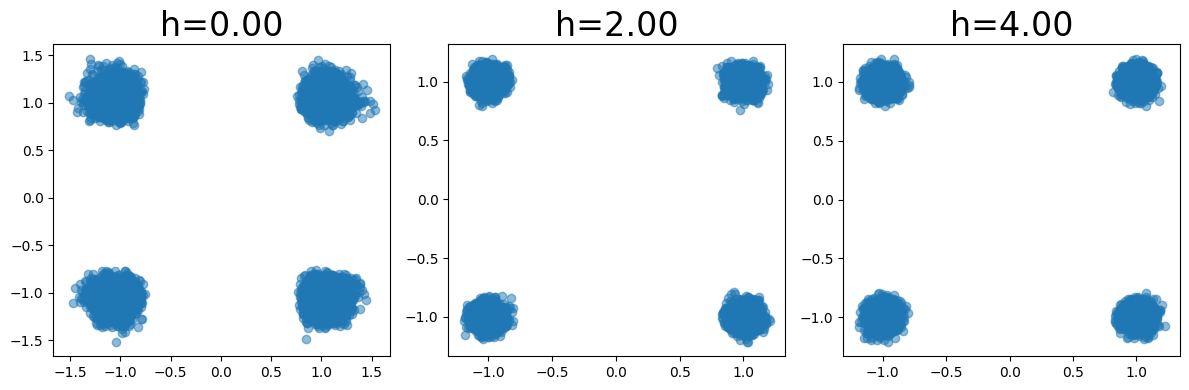

Image has been saved to vis_the_emp_distribution.png


In [25]:
# visualization of the emprical distribution
visualize_diffusion_process_2d(xs=tilde_x_t, titles=[f"h={h:.2f}" for h in h_alphas], savename="vis_the_emp_distribution.png")

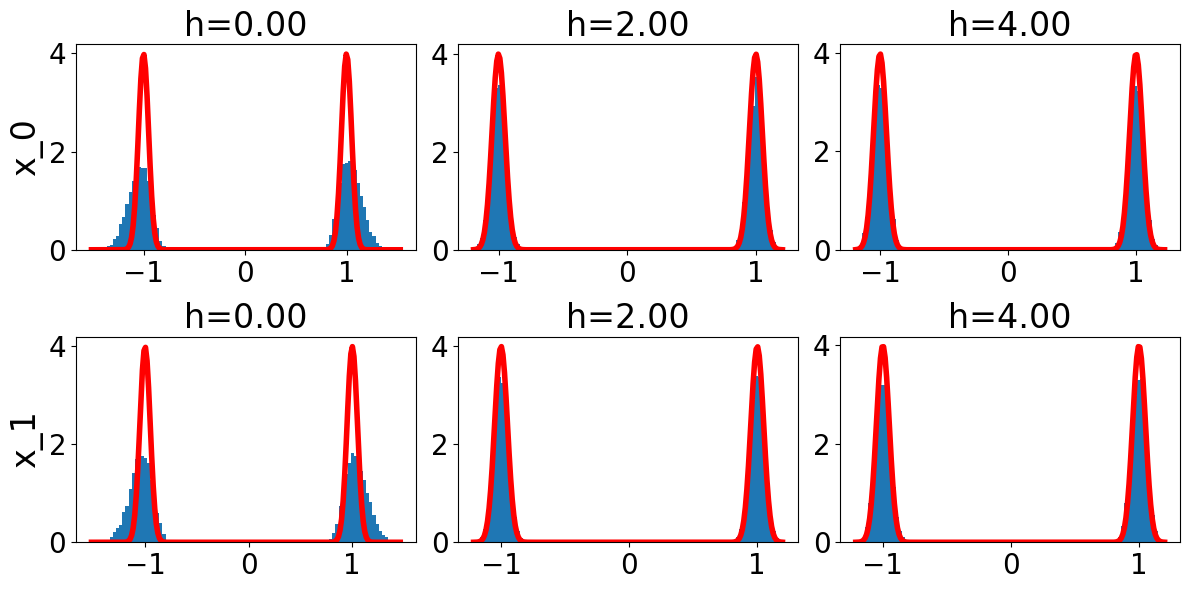

In [26]:
# visualization of the marginal distribution
visualize_diffusion_process_2d_marginal(x_t=tilde_x_t, titles=[f"h={h:.2f}" for h in h_alphas], density_func=true_data.marginal, title=None, savename="vis_the_marginal_distribution.png")

In [27]:
data = list()

for h in np.linspace(start=0.0, stop=h_alphas[-1], num=21, endpoint=True)[::-1]:
# for sa in [sf_alpha]:

    x_0 = true_data.sample(sample_size)
    x_0 = torch.from_numpy(x_0).view(-1, data_dim)

    x_0_gen = model.sample(x_t=x_T, T=0.0, N=reverse_N, to_numpy=True, sf_alpha=h, exact_score_fn=true_data.exact_score_t, corrupter=Corrupter, eps=eps)

    js, kl, wd = evaluate_2d(true_data=x_0.detach().numpy(), fake_data=x_0_gen, x0=x0, x1=x1, y0=y0, y1=y1)

    print(f"h={h:.2f}: js={js:.4f}, kl={kl:.4f}, wd={wd:.4f}")

    data.append([h, js, kl, wd])

data = np.array(data)

visualize_line(data=data[:, 1], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with JS divergence", savename="eval_JS_2.png")
visualize_line(data=data[:, 2], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with KL divergence", savename="eval_KL_2.png")
visualize_line(data=data[:, 3], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with Wasserstein distance", savename="eval_WD_2.png")



KeyboardInterrupt: 